# 可视化城市可达性

主要利用[pandana](https://udst.github.io/pandana/network.html) (v0.4.4)对城市内各个设施（地铁站，学校等）可达性进行可视化，安装pandana方法点[这里](https://udst.github.io/pandana/installation.html)<br/>
这里可达性的是用**路网节点到兴趣点的距离**来度量的  

Pandana is a Python library for network analysis that uses contraction hierarchies to calculate super-fast travel accessibility metrics and shortest paths.   
<br/>pandana快速上手[教程]( https://github.com/UDST/pandana/blob/master/examples/Example.ipynb)

## 从OpenStreetMap下载路网和POI(兴趣点）

In [1]:
#导入需要的库
import pandana, matplotlib.pyplot as plt
from pandana.loaders import osm
%matplotlib inline
import pandas as pd
import pandana as pdna

In [1]:
#利用OSM的api获取指定区域内的POI信息
# bbox = [30.66, 120.85,31.89, 122.20] #上海的经纬度范围
# amenity = 'school' #兴趣点种类
# pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags='"amenity"="{}"'.format(amenity))
# pois.to_csv("{}.csv".format(amenity),index=False, encoding='utf-8')

**不推荐**上面下载poi的方法，很慢，而且并不靠谱<br/>
建议通过国内的[高德api](https://lbs.amap.com/api/webservice/guide/api/search)获取POI，虽然有限制，但是学习用是足够了<br/>
本文已经提供了上海关于学校，地铁站，公交站，餐饮，医疗，电影院&&剧院的poi文件

In [3]:
# 根据给定的经纬度范围利用OSM下载区域内路网
bbox = [30.66, 120.85,31.89, 122.20] #上海的经纬度范围
network_filename='./shapefile/shanghai_net.h5'#保存路网文件路径
network = osm.network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
network=pandana.Network(network[0]["x"],network[0]["y"], network[1]["from"], network[1]["to"],
                 network[1][["distance"]])

In [5]:
#去除一些低连接度的节点，并保存路网文件
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
network.save_hdf5(network_filename, rm_nodes=lcn)

## 导入路网和POI

In [4]:
#导入路网
network = pandana.network.Network.from_hdf5("./shapefile/shanghai_net.h5")
#对路网进行预计算，方便后面的查询
distance = 2000#距离是指计算的距离范围，如2000代表查询范围路网节点中2000m以内
network.precompute(distance + 1)#预计算

In [56]:
network.nodes_df.head()  #查看网络的节点

,x,y
id,,
61104104,121.579137,31.244254
61104668,121.571341,31.240739
61104683,121.570549,31.241960
61104687,121.572230,31.238660
61114908,121.565010,31.239023


In [57]:
network.edges_df.head() #查看网络的边

from         to    distance
61104104 99925068   61104104   99925068  107.604314
61104668 70970606   61104668   70970606  524.709177
         88082377   61104668   88082377  233.410192
61104683 87723728   61104683   87723728   15.311296
         127444211  61104683  127444211  393.763253

In [ ]:
'''
# 不能直接保存Pandana网络对象，但可以轻松地从节点和边重新创建它
network.nodes_df.to_csv('nodes.csv')
network.edges_df.to_csv('edges.csv')
nodes = pd.read_csv('nodes.csv', index_col=0)
edges = pd.read_csv('edges.csv', index_col=[0,1])
network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])

'''

In [5]:
#导入poi
pois = pd.read_csv('./data-sample/上海poi/shanghai_hotpot.csv')

In [6]:
#看看poi的样子，这里读取的是上海的火锅店
pois.head(5)

,name,address,adname,pname,type,lat,lon
0,海底捞火锅(打浦路店),打浦路1号金玉兰广场4层,黄浦区,上海市,餐饮服务;中餐厅;火锅店,31.206898,121.466603
1,三人行骨头王火锅(浙江路店),浙江南路8号,黄浦区,上海市,餐饮服务;中餐厅;火锅店,31.231981,121.477108
2,傣妹休闲·火锅(三牌楼路店),三牌楼路11号,黄浦区,上海市,餐饮服务;中餐厅;火锅店,31.226199,121.487951
3,春秋火锅(复兴中路店),复兴中路581号(近瑞金二路),黄浦区,上海市,餐饮服务;中餐厅;火锅店,31.216771,121.461280
4,新梅居(宁海一店),宁海东路303号,黄浦区,上海市,餐饮服务;中餐厅;火锅店,31.229821,121.475336


## 对POI进行集计查询

集计给定距离范围内兴趣点属性，可以是离散可以是连续，取决于兴趣点属性<br/>
如统计路网节点500m内火锅店个数，是离散值统计<br/>
如统计路网节点500m内火锅店平均营业额，是连续值统计（需要知道每个火锅店的营业额）<br/>
**下面示例是统计500m内的火锅店数量**

In [9]:
#让poi与路网建立联系
x, y = pois['lon'], pois['lat']
node_ids = network.get_node_ids(x, y)  #Assign node_ids to data specified by x_col and y_col.
network.set(node_ids) #Characterize urban space with a variable that is related to nodes in the network.

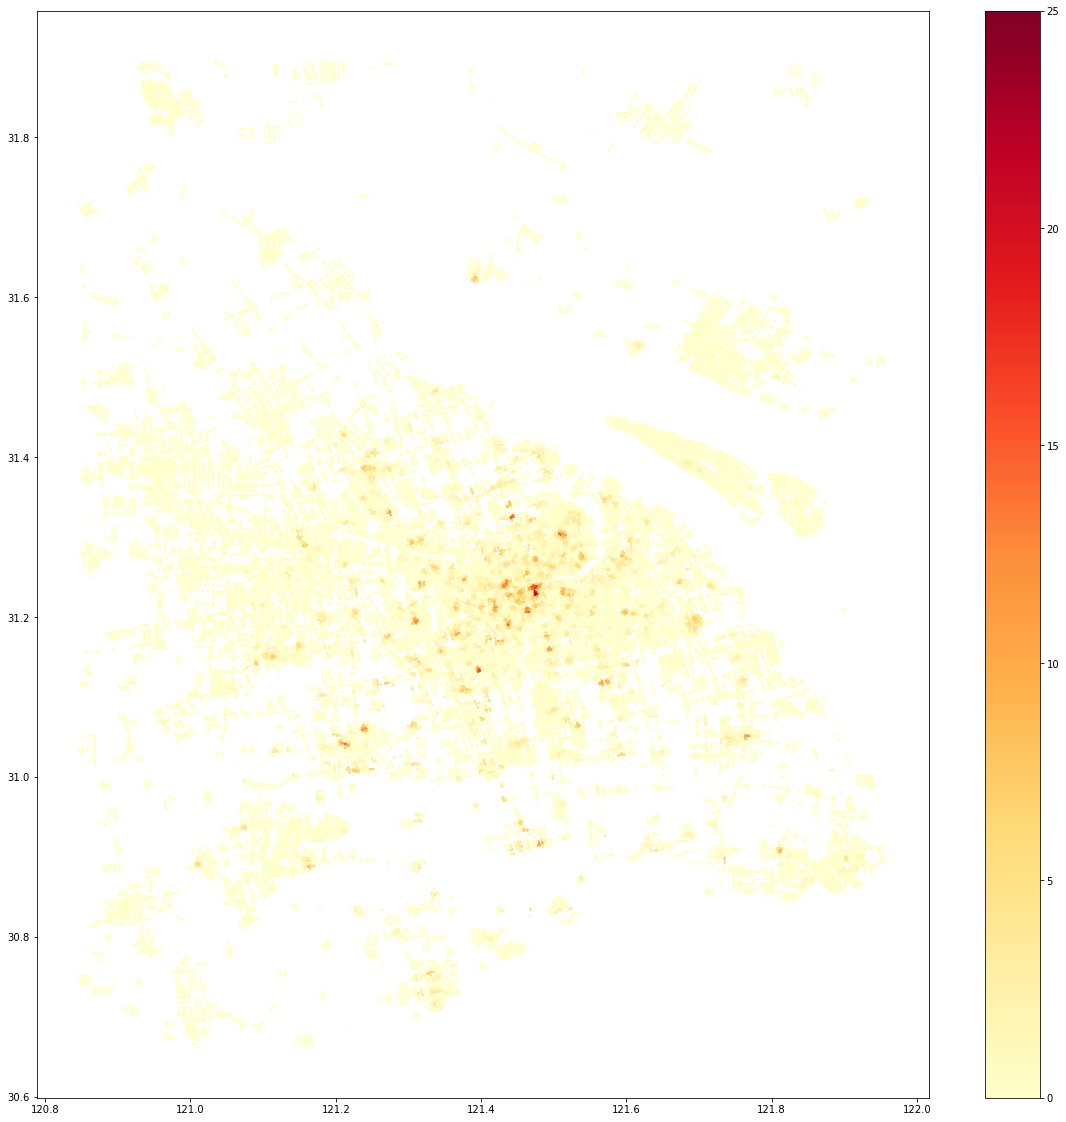

In [49]:
'''
Modified in Pandana v0.6 to eliminate usage of Matplotlib’s deprecated Basemap toolkit.
No longer accepts bmap_kwargs and no longer returns a Basemap object.
'''
s = network.aggregate(500, type="count", decay="linear") #统计500米内火锅店数量

fig_kwargs = {'figsize': [20, 20]}
#bmap_kwargs = {'suppress_ticks': False, 'resolution': 'h', 'epsg': '4326'}
plot_kwargs = {'cmap': 'YlOrRd', 's': 8, 'edgecolor': 'none'}
sf_bbox = [30.66, 120.85,31.89, 122.20]
ax = network.plot(s, bbox=sf_bbox,plot_type='scatter',
         fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs)

plt.show()

## 对POI进行近邻查询

近邻查询路网节点给定距离范围内到最近的几个兴趣点距离<br/>
**下面示例是查询路网节点2000m内最近的7个火锅店距离**

In [10]:
#初始化
network.init_pois(num_categories=1, max_dist=distance, max_pois=7)

In [11]:
network.set_pois(category='my_poi', x_col=pois['lon'], y_col=pois['lat'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [12]:
# 对路网中每个节点执行n最近邻（第那个最近）查询
#num_pois=7指查询7个最近的兴趣点
#category的值需要与上一格子里的category一致
access = network.nearest_pois(distance=distance, category='my_poi', num_pois=7)

In [13]:
# 查看一下查询结果
# 7列分别代表每个节点到最近7个火锅店的距离
access.head()

,1,2,3,4,5,6,7
id,,,,,,,
61104104,614.219971,890.255981,890.255981,890.255981,1081.850952,1108.729004,1394.362061
61104668,243.539001,728.091003,895.786987,956.140015,1192.686035,1273.161987,1339.369995
61104683,398.856995,740.468994,800.822021,865.776978,1037.368042,1117.843994,1184.052002
61104687,4.403000,529.015991,1142.003052,1202.355957,1438.901978,1519.378052,1585.586060
61114908,1003.495972,1335.258057,1375.729980,1436.083008,1470.416016,1660.781006,1660.781006


## 可视化可达性

In [47]:
# 利用matplotlib画图的参数
bbox=[30.66, 120.85,31.89, 122.20]

fig_kwargs = {'facecolor':'w', 
              'figsize':(20,20)}

plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# 生成colorbar的参数
cbar_kwargs = {}

#bmap_kwargs = {'suppress_ticks': False, 'resolution': 'h', 'epsg': '4326'}

# 设定背景颜色
bgcolor = 'k'

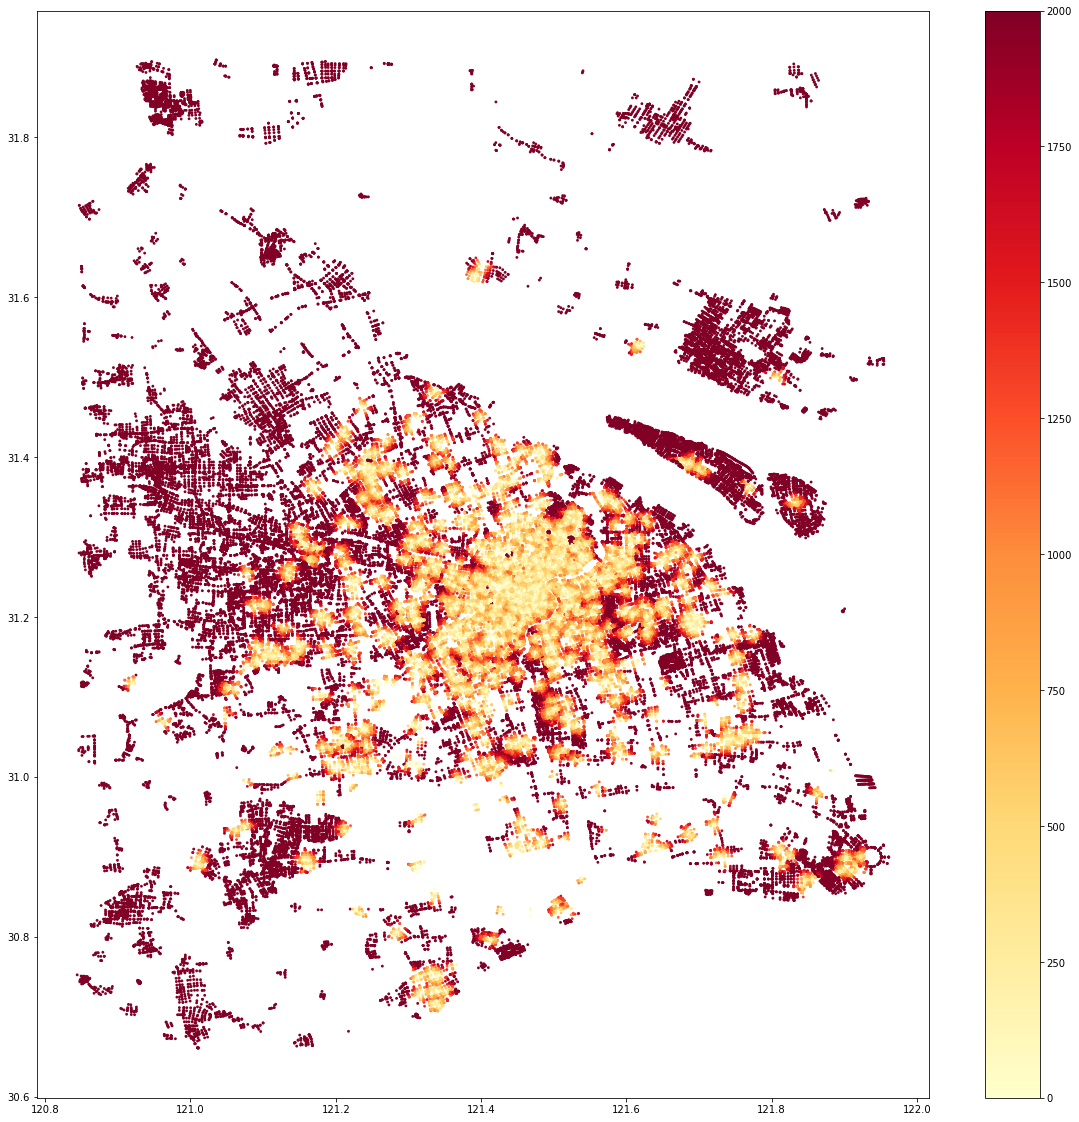

In [52]:
# 可视化路网节点到第n近的POI的距离

n = 1
amenity='hotpot'
ax = network.plot(access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                              cbar_kwargs=cbar_kwargs)

# fig.savefig('resource/{}.png'.format(amenity), dpi=200, bbox_inches='tight')
plt.show()

通过以上代码，你就可以自由更换路网文件和poi文件，画出你想画的城市可达性！